In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import time
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# 🧠 Deep Learning Practical Assignment (Adult Income Dataset)

## 📌 Dataset
We will use the **Adult Income dataset** (also known as the Census Income dataset).  
The task is to predict whether a person earns **more than $50K/year** based on demographic and employment attributes.

---


In [2]:
# Option 1: Using OpenML via scikit-learnfrom sklearn.utils import class_weight
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame

print(df.head())
print(df.shape)  # (48842, 15)

# Separate features and target
X = df.drop(columns="class")
y = df["class"]


   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country  class  
0       

## Part 0: Data Preparation
1. Load the dataset into a DataFrame.
2. Split the data into **training, validation, and test sets**.  
   - Suggested: 70% training, 15% validation, 15% test.
3. Apply any necessary preprocessing:
   - Handle categorical features (encoding).
   - Scale numerical features if needed.
4. After training your models, always report results on:
   - **Training accuracy**
   - **Validation accuracy**
   - **Test accuracy**
5. At the end of the assignment, **compare all methods** across train, validation, and test sets.


In [3]:
df.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


In [5]:
num_f = df.select_dtypes(exclude='category').columns.to_list()
num_f

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [6]:
cat_f = df.select_dtypes(include='category').columns.to_list()
cat_f

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'class']

In [7]:
df.isna().mean() # Nulls are not alot can be filled with mode or dropped

,0
age,0.000000
workclass,0.057307
fnlwgt,0.000000
education,0.000000
education-num,0.000000
marital-status,0.000000
occupation,0.057512
relationship,0.000000
race,0.000000
sex,0.000000


In [8]:
df.duplicated().sum() # drop duplicated

np.int64(52)

# Exploratory Data Analysis

## Numerical Features Exploration

In [9]:
df[num_f].describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [10]:
# for col in num_f:
#   print(f"{col} feature uniques : {df[col].unique()}")

In [11]:
num_f

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

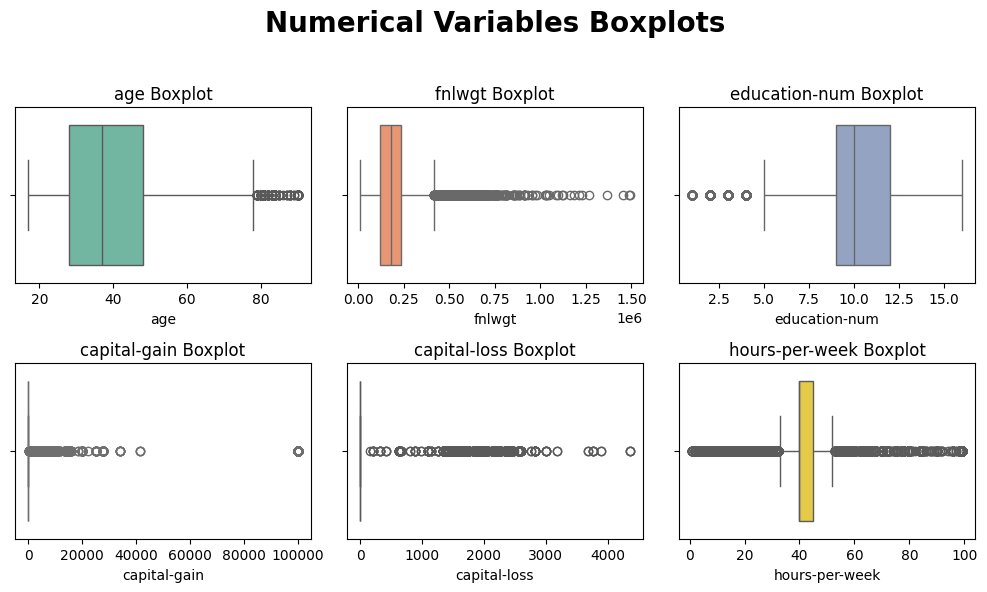

In [12]:
plt.figure(figsize=(10,6))
palette = sns.color_palette("Set2", n_colors=len(num_f))
for i, col in enumerate(num_f):

  plt.subplot(2, 3, i+1)
  sns.boxplot(data=df, x=col, color=palette[i])
  plt.title(f"{col} Boxplot")

plt.suptitle("Numerical Variables Boxplots", fontsize=20, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])

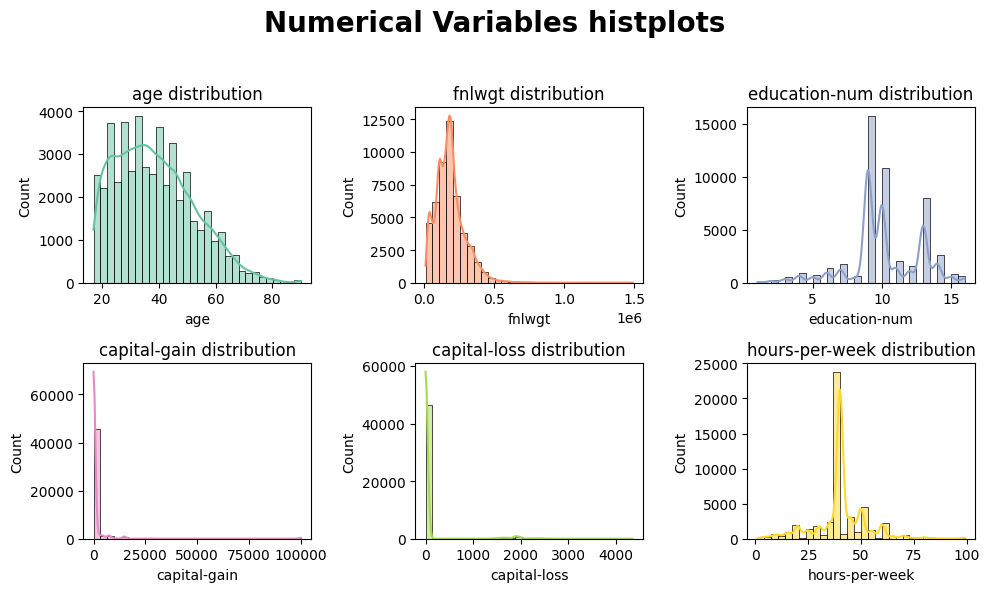

In [13]:
plt.figure(figsize=(10,6))
palette = sns.color_palette("Set2", n_colors=len(num_f))
for i, col in enumerate(num_f):

  plt.subplot(2, 3, i+1)
  sns.histplot(data=df,x=col,bins=30,kde=True, color=palette[i])
  plt.title(f"{col} distribution")

plt.suptitle("Numerical Variables histplots", fontsize=20, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])

## Categorical Exploration

In [14]:
cat_f

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'class']

In [15]:
for col in cat_f:
  print(f"{col} feature uniques : {df[col].unique()}\n")

workclass feature uniques : ['Private', 'Local-gov', NaN, 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']
Categories (8, object): ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc',
                         'Self-emp-not-inc', 'State-gov', 'Without-pay']

education feature uniques : ['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool']
Length: 16
Categories (16, object): ['10th', '11th', '12th', '1st-4th', ..., 'Masters', 'Preschool',
                          'Prof-school', 'Some-college']

marital-status feature uniques : ['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse']
Categories (7, object): ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
                         'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

occupation feature uniques : ['Machine-op-inspct

- 'workclass'= > nominal,
- 'education'=> check with education num
- 'marital-status' => nominal (separated = divorced)
- 'occupation'=> nominal
- 'relationship'=> nominal (Wife and husband can be categoried as married)
- 'race'=> nominal
- 'sex'=> nominal
- 'native-country'=> nomianl
- 'class'=> ordinal

In [16]:
# df['education'].unique().tolist()

In [17]:
df.groupby("education", observed=False)["education-num"].unique().sort_values()  # Drop education and keep education num

,education-num
education,
Preschool,[1]
1st-4th,[2]
5th-6th,[3]
7th-8th,[4]
9th,[5]
10th,[6]
11th,[7]
12th,[8]
HS-grad,[9]


In [18]:
# df['occupation'].unique().tolist()

In [19]:
cat_f

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'class']

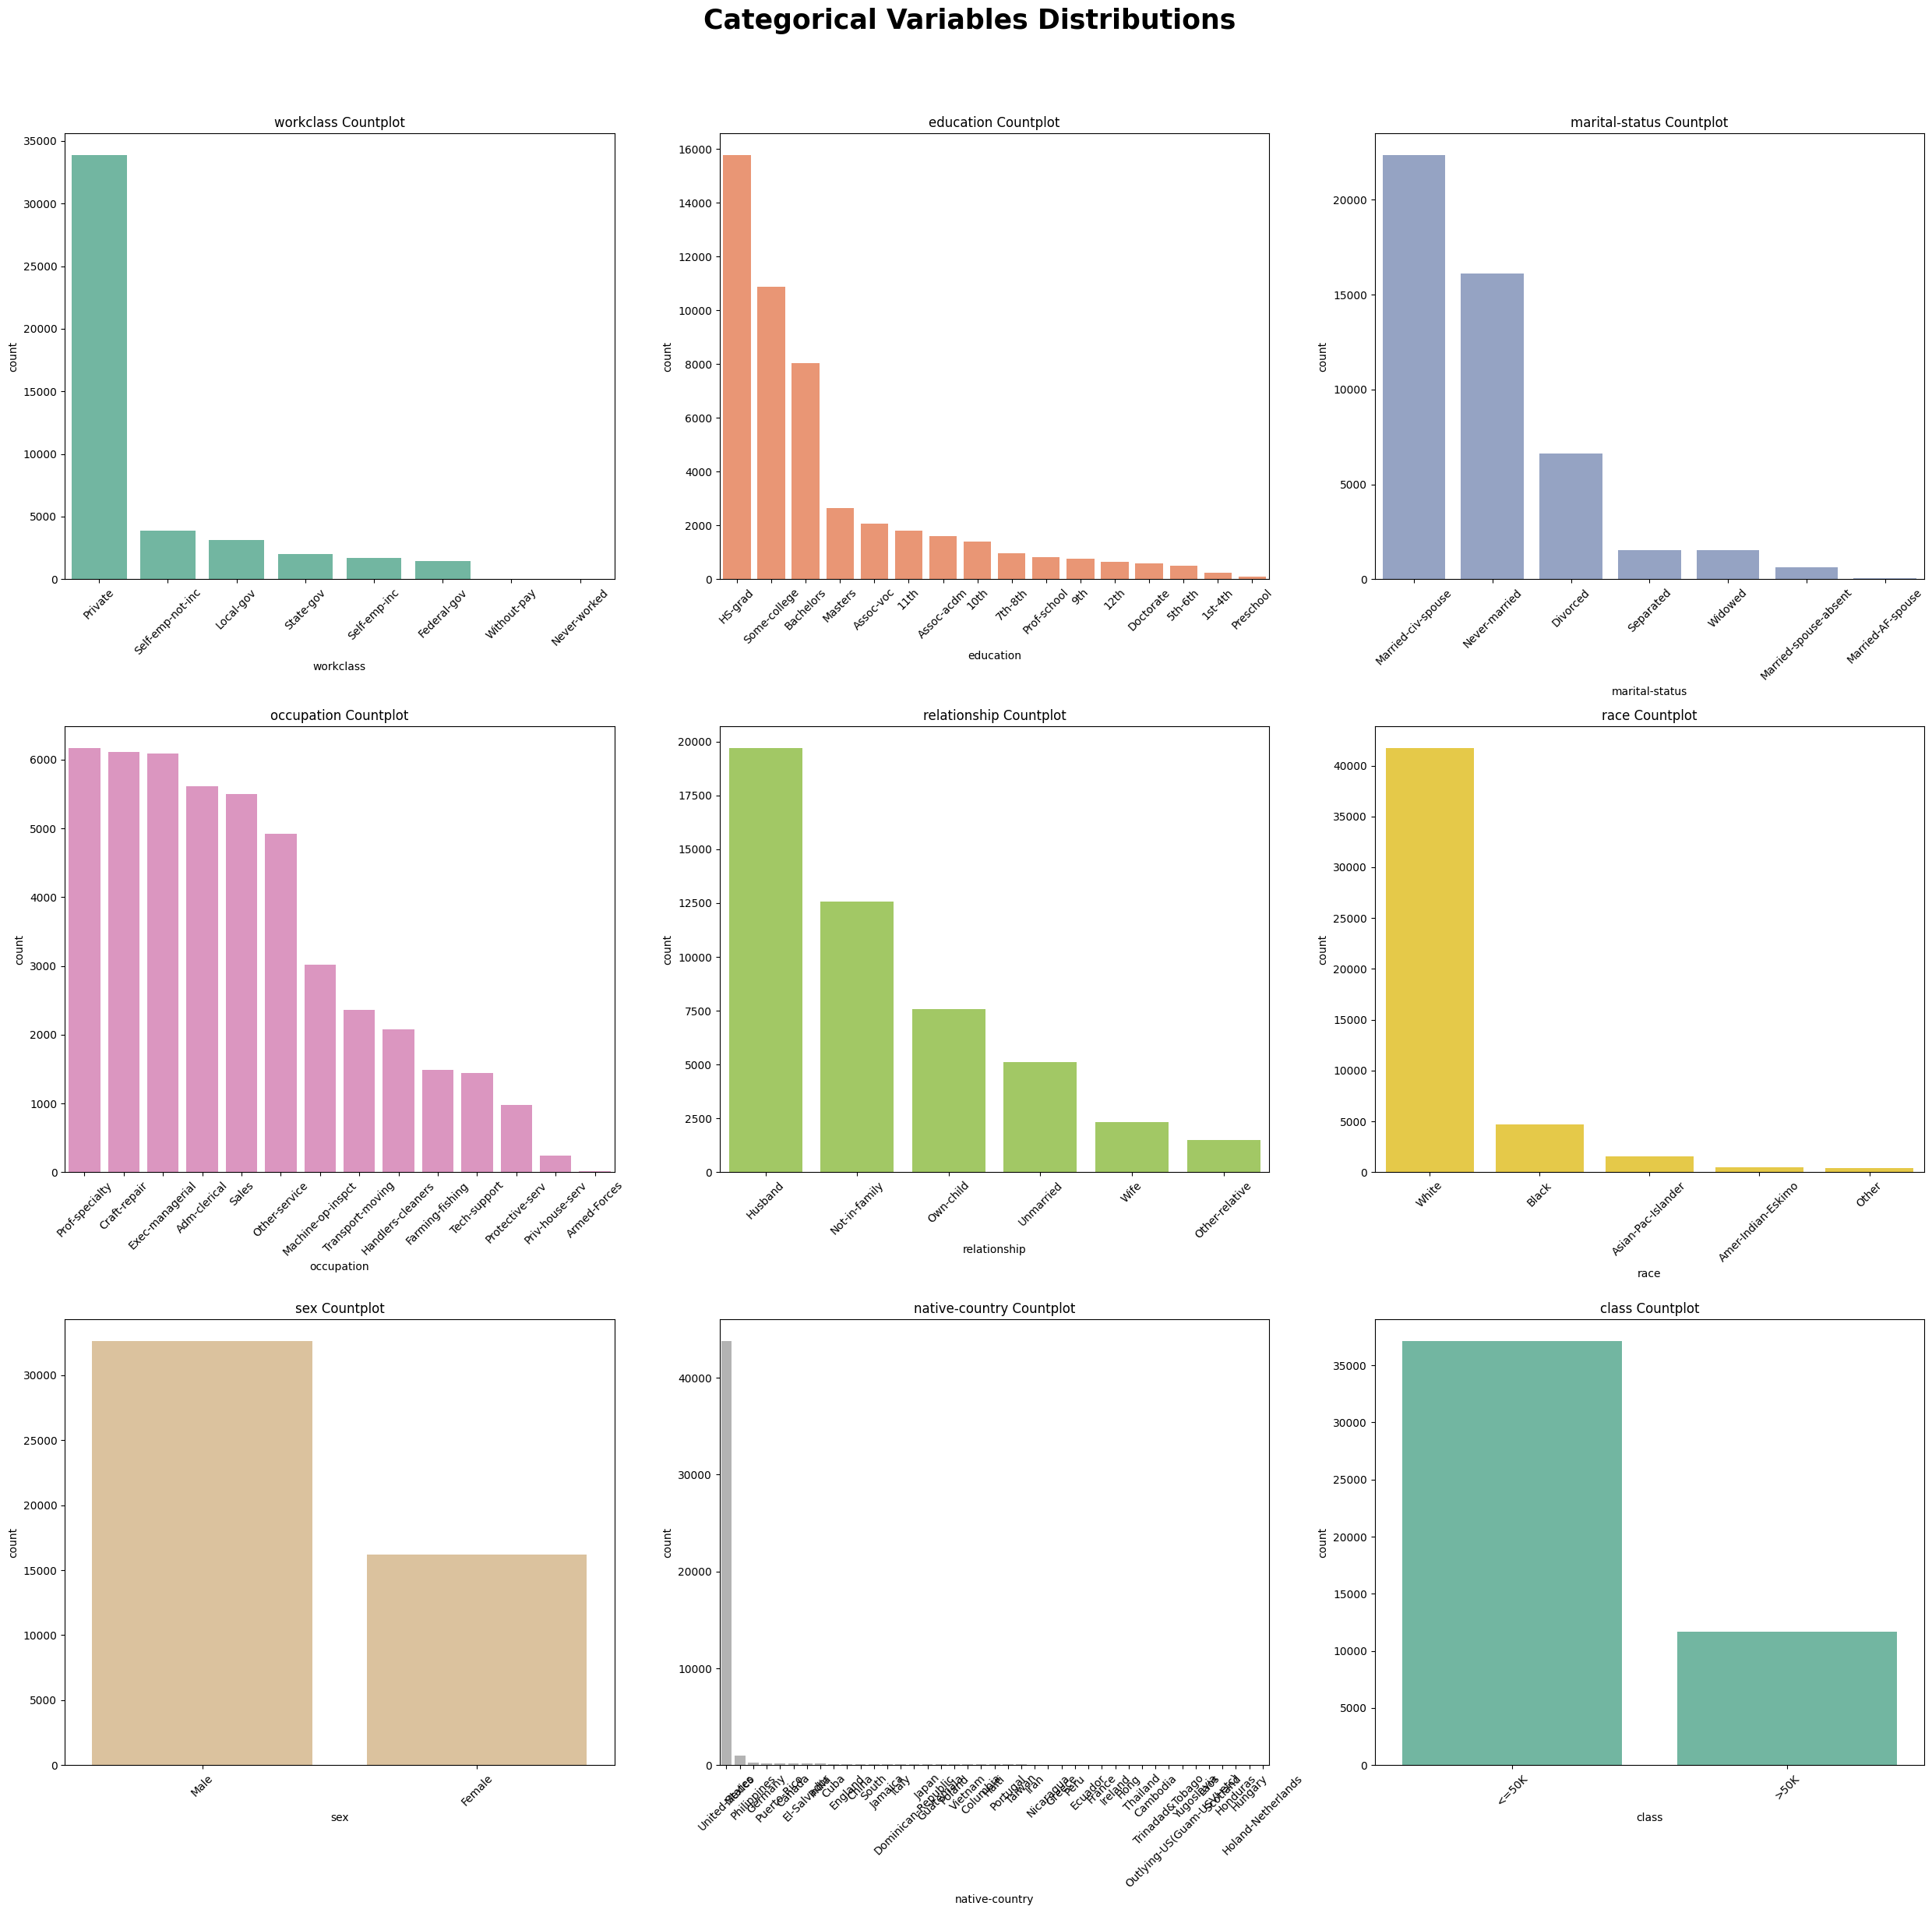

In [20]:
plt.figure(figsize=(25,25))
palette = sns.color_palette("Set2", n_colors=len(cat_f))
for i, col in enumerate(cat_f):
    plt.subplot(3, 3, i+1)
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order = order, color=palette[i])
    plt.title(f"{col} Countplot")
    plt.xticks(rotation=45)

plt.suptitle("Categorical Variables Distributions", fontsize=25, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])

In [21]:
df['native-country'].value_counts()

,count
native-country,
United-States,43832
Mexico,951
Philippines,295
Germany,206
Puerto-Rico,184
Canada,182
El-Salvador,155
India,151
Cuba,138


# Preprocessing

- 3 features with nulls 5%, 5%, 1% => since data is severly unbalanced i will fill with missing the model may be able to learn a pattern
- 52 duplicates => drop
- Drop education (substitute with education num)
- Unbalanced data
- Scale numerical Features
- Enode cat features

In [22]:
cat_f


['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'class']

In [23]:
miss = ['workclass',
 'occupation',
 'native-country']

In [24]:
for col in miss:
    df[col] = df[col].cat.add_categories("missing")
    df[col] = df[col].fillna("missing")

In [25]:
# df.isna().mean()

In [26]:
df.drop_duplicates(inplace=True)

In [27]:
# df.duplicated().sum()

In [28]:
df.drop(columns='education', inplace =True)

In [29]:
cat_f.pop(cat_f.index("education"))

'education'

In [30]:
cat_f

['workclass',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'class']

In [31]:
normal = ['age', 'hours-per-week', 'education', ]
skewed = ['fnlwgt', 'capital-gain', 'capital-loss']

In [32]:
for col in cat_f:
  print(f"{col} feature uniques : {df[col].nunique()}\n")

workclass feature uniques : 9

marital-status feature uniques : 7

occupation feature uniques : 15

relationship feature uniques : 6

race feature uniques : 5

sex feature uniques : 2

native-country feature uniques : 42

class feature uniques : 2



In [33]:
label = ['sex', 'class']
onehot= ['workclass', 'marital-status','occupation', 'relationship', 'race', 'native-country' ]
high_dim = ['native-country', 'occupation', 'workclass']

In [34]:
X = df.drop(columns = 'class')
y = df['class']

In [35]:
xtrain, xtemp, ytrain, ytemp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [36]:
xtest, xval, ytest, yval = train_test_split(xtemp, ytemp, test_size=0.5, random_state=42, stratify=ytemp)

In [37]:
le = LabelEncoder()
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [38]:
type(ytrain)

pandas.core.series.Series

In [39]:
xtrain['sex'] = le.fit_transform(xtrain['sex'])
xtest['sex'] = le.transform(xtest['sex'])
xval['sex'] = le.transform(xval['sex'])

In [40]:
ytrain = pd.Series(le.fit_transform(ytrain), index=ytrain.index, name="class")
ytest = pd.Series(le.transform(ytest), index=ytest.index, name="class")
yval = pd.Series(le.transform(yval), index=yval.index, name="class")

In [41]:
X_train_ohe = pd.DataFrame(
    ohe.fit_transform(xtrain[onehot]),
    columns=ohe.get_feature_names_out(onehot),
    index=xtrain.index
)

In [42]:
X_test_ohe = pd.DataFrame(
    ohe.transform(xtest[onehot]),
    columns=ohe.get_feature_names_out(onehot),
    index=xtest.index
)

In [43]:
X_val_ohe = pd.DataFrame(
    ohe.transform(xval[onehot]),
    columns=ohe.get_feature_names_out(onehot),
    index=xval.index
)

In [44]:
skewed

['fnlwgt', 'capital-gain', 'capital-loss']

In [45]:
for col in skewed:
  xtrain[col] = np.log1p(xtrain[col])
  xtest[col] = np.log1p(xtest[col])
  xval[col] = np.log1p(xval[col])

In [46]:
ss = StandardScaler()

In [47]:
xtrain[num_f] = ss.fit_transform(xtrain[num_f])
xtest[num_f] = ss.transform(xtest[num_f])
xval[num_f] = ss.transform(xval[num_f])

In [48]:
xtrain.drop(columns=onehot, inplace=True)
xtest.drop(columns=onehot, inplace=True)
xval.drop(columns=onehot, inplace=True)

In [49]:
xtrain.head()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week
35760,1.486419,-0.143857,2.306734,1,-0.296806,-0.222377,0.773125
13966,-1.071259,1.482488,-0.420321,0,-0.296806,-0.222377,0.773125
18617,0.171042,0.005955,-1.199479,1,-0.296806,-0.222377,-0.033554
32232,-0.559723,-0.016893,-0.420321,0,-0.296806,-0.222377,-1.082236
4686,-0.559723,-2.544287,-0.030742,0,-0.296806,-0.222377,-0.033554


In [50]:
xtrain = pd.concat([xtrain, X_train_ohe], axis=1)
xtest = pd.concat([xtest, X_test_ohe], axis=1)
xval = pd.concat([xval, X_val_ohe], axis=1)

In [51]:
xtrain.shape

(34153, 85)

# Models

In [52]:
ytrain.unique()

array([1, 0])

In [ ]:
# yval.info()

In [53]:
xtrain.shape

(34153, 85)

In [ ]:
model = Sequential([
    Input(shape=(85,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=10, batch_size=16)

Epoch 1/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8286 - loss: 0.3610 - val_accuracy: 0.8509 - val_loss: 0.3215
Epoch 2/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8536 - loss: 0.3215 - val_accuracy: 0.8561 - val_loss: 0.3226
Epoch 3/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8517 - loss: 0.3260 - val_accuracy: 0.8537 - val_loss: 0.3240
Epoch 4/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8508 - loss: 0.3256 - val_accuracy: 0.8550 - val_loss: 0.3204
Epoch 5/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8516 - loss: 0.3286 - val_accuracy: 0.8559 - val_loss: 0.3194
Epoch 6/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8556 - loss: 0.3185 - val_accuracy: 0.8542 - val_loss: 0.3205
Epoch 7/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8562 - loss: 0.3168 - val_accuracy: 0.8564 - val_loss: 0.3199
Epoch 8/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8567 - loss: 0.3151 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

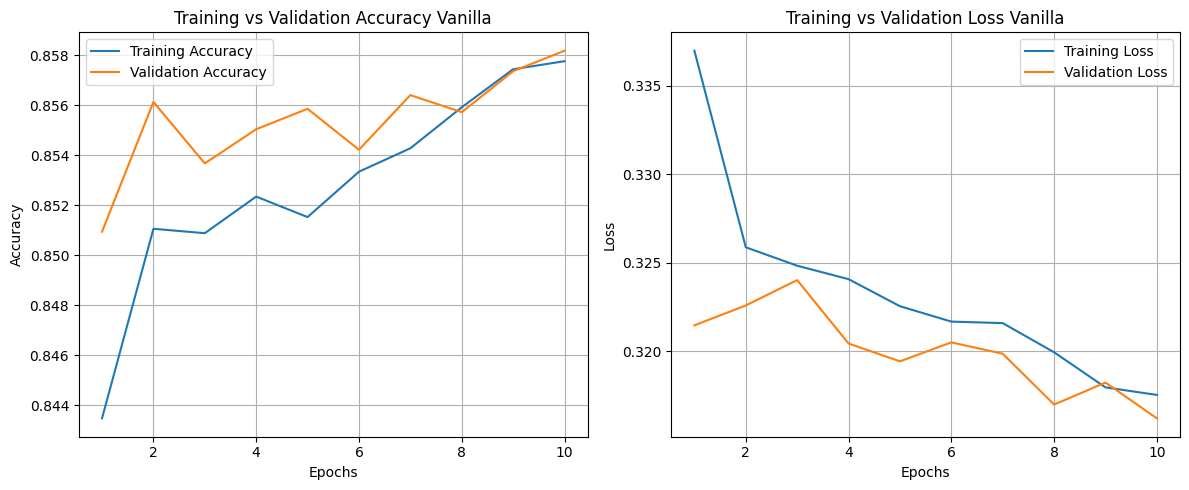

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy Vanilla')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss Vanilla')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.savefig("64_32_output_batch16_no_opt.png", dpi=300)


## Part 1: Optimizers
1. Train the same neural network using:
   - Stochastic Gradient Descent (SGD)
   - SGD with Momentum
   - Adam
2. Compare the training and validation accuracy for each optimizer.
3. Which optimizer converges the fastest? Which gives the best generalization?
4. Explain *why* Adam often performs better than plain SGD.

---


## SDG

In [ ]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(85, )))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = SGD(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(xtrain, ytrain,
                    validation_data=(xval, yval),
                    epochs=10,
                    batch_size=16)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7793 - loss: 0.4621 - val_accuracy: 0.8466 - val_loss: 0.3323
Epoch 2/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8455 - loss: 0.3300 - val_accuracy: 0.8508 - val_loss: 0.3223
Epoch 3/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8526 - loss: 0.3201 - val_accuracy: 0.8520 - val_loss: 0.3192
Epoch 4/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8493 - loss: 0.3255 - val_accuracy: 0.8546 - val_loss: 0.3166
Epoch 5/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8495 - loss: 0.3170 - val_accuracy: 0.8542 - val_loss: 0.3148
Epoch 6/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8524 - loss: 0.3160 - val_accuracy: 0.8534 - val_loss: 0.3144
Epoch 7/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8515 - loss: 0.3207 - val_accuracy: 0.8559 - val_loss: 0.3127
Epoch 8/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8514 - loss: 0.314

## SDG with Momentum

In [ ]:
model2 = Sequential([
    Input(shape=(85,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer = SGD(learning_rate = 0.01, momentum = 0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(xtrain, ytrain,
                    validation_data=(xval, yval),
                    epochs=10,
                    batch_size=16)

Epoch 1/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8251 - loss: 0.3653 - val_accuracy: 0.8516 - val_loss: 0.3186
Epoch 2/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8434 - loss: 0.3322 - val_accuracy: 0.8583 - val_loss: 0.3163
Epoch 3/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8479 - loss: 0.3230 - val_accuracy: 0.8568 - val_loss: 0.3180
Epoch 4/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8512 - loss: 0.3157 - val_accuracy: 0.8526 - val_loss: 0.3179
Epoch 5/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8521 - loss: 0.3169 - val_accuracy: 0.8571 - val_loss: 0.3109
Epoch 6/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8540 - loss: 0.3122 - val_accuracy: 0.8560 - val_loss: 0.3112
Epoch 7/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8570 - loss: 0.3057 - val_accuracy: 0.8531 - val_loss: 0.3131
Epoch 8/10
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8577 - loss: 0.3106

## ADAM

In [64]:
model3 = Sequential([
    Input(shape=(85,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer = Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(xtrain, ytrain,
                    validation_data=(xval, yval),
                    epochs=20,
                    batch_size=16, verbose=2)

Epoch 1/20
2135/2135 - 5s - 3ms/step - accuracy: 0.8421 - loss: 0.3357 - val_accuracy: 0.8511 - val_loss: 0.3196
Epoch 2/20
2135/2135 - 6s - 3ms/step - accuracy: 0.8519 - loss: 0.3192 - val_accuracy: 0.8574 - val_loss: 0.3122
Epoch 3/20
2135/2135 - 11s - 5ms/step - accuracy: 0.8521 - loss: 0.3147 - val_accuracy: 0.8567 - val_loss: 0.3137
Epoch 4/20
2135/2135 - 4s - 2ms/step - accuracy: 0.8564 - loss: 0.3100 - val_accuracy: 0.8575 - val_loss: 0.3099
Epoch 5/20
2135/2135 - 5s - 2ms/step - accuracy: 0.8567 - loss: 0.3060 - val_accuracy: 0.8568 - val_loss: 0.3113
Epoch 6/20
2135/2135 - 5s - 3ms/step - accuracy: 0.8612 - loss: 0.3017 - val_accuracy: 0.8563 - val_loss: 0.3093
Epoch 7/20
2135/2135 - 10s - 5ms/step - accuracy: 0.8629 - loss: 0.2987 - val_accuracy: 0.8623 - val_loss: 0.3064
Epoch 8/20
2135/2135 - 5s - 2ms/step - accuracy: 0.8615 - loss: 0.2959 - val_accuracy: 0.8583 - val_loss: 0.3066
Epoch 9/20
2135/2135 - 6s - 3ms/step - accuracy: 0.8642 - loss: 0.2936 - val_accuracy: 0.8621 

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ytrain),
    y=ytrain
)
class_weights_dict = dict(zip(np.unique(ytrain), class_weights))
print(class_weights_dict)

In [69]:
model3 = Sequential([
    Input(shape=(85,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer = Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(xtrain, ytrain,
                    validation_data=(xval, yval),
                    epochs=20,
                    batch_size=16,
                    class_weight=class_weights_dict,
                    verbose=2)

Epoch 1/20
2135/2135 - 7s - 3ms/step - accuracy: 0.7915 - loss: 0.3989 - val_accuracy: 0.7875 - val_loss: 0.4073
Epoch 2/20
2135/2135 - 4s - 2ms/step - accuracy: 0.8021 - loss: 0.3802 - val_accuracy: 0.8125 - val_loss: 0.3780
Epoch 3/20
2135/2135 - 6s - 3ms/step - accuracy: 0.8071 - loss: 0.3735 - val_accuracy: 0.8276 - val_loss: 0.3515
Epoch 4/20
2135/2135 - 4s - 2ms/step - accuracy: 0.8113 - loss: 0.3684 - val_accuracy: 0.8179 - val_loss: 0.3719
Epoch 5/20
2135/2135 - 4s - 2ms/step - accuracy: 0.8123 - loss: 0.3623 - val_accuracy: 0.8168 - val_loss: 0.3620
Epoch 6/20
2135/2135 - 6s - 3ms/step - accuracy: 0.8148 - loss: 0.3584 - val_accuracy: 0.8049 - val_loss: 0.3896
Epoch 7/20
2135/2135 - 4s - 2ms/step - accuracy: 0.8163 - loss: 0.3540 - val_accuracy: 0.8240 - val_loss: 0.3501
Epoch 8/20
2135/2135 - 5s - 2ms/step - accuracy: 0.8188 - loss: 0.3505 - val_accuracy: 0.8027 - val_loss: 0.3862
Epoch 9/20
2135/2135 - 6s - 3ms/step - accuracy: 0.8196 - loss: 0.3465 - val_accuracy: 0.8151 - 

In [ ]:
sdgacc = history.history['accuracy']
sdgloss = history.history['loss']
sdgval_acc = history.history['val_accuracy']
sdgval_loss = history.history['val_loss']
epochs = range(1, len(sdgacc)+1)

sdgmacc = history2.history['accuracy']
sdgmloss = history2.history['loss']
sdgmval_acc = history2.history['val_accuracy']
sdgmval_loss = history2.history['val_loss']
epochs2 = range(1, len(sdgmacc)+1)

adamacc = history3.history['accuracy']
adamloss = history3.history['loss']
adamval_acc = history3.history['val_accuracy']
adamval_loss = history3.history['val_loss']
epochs3 = range(1, len(adamacc)+1)

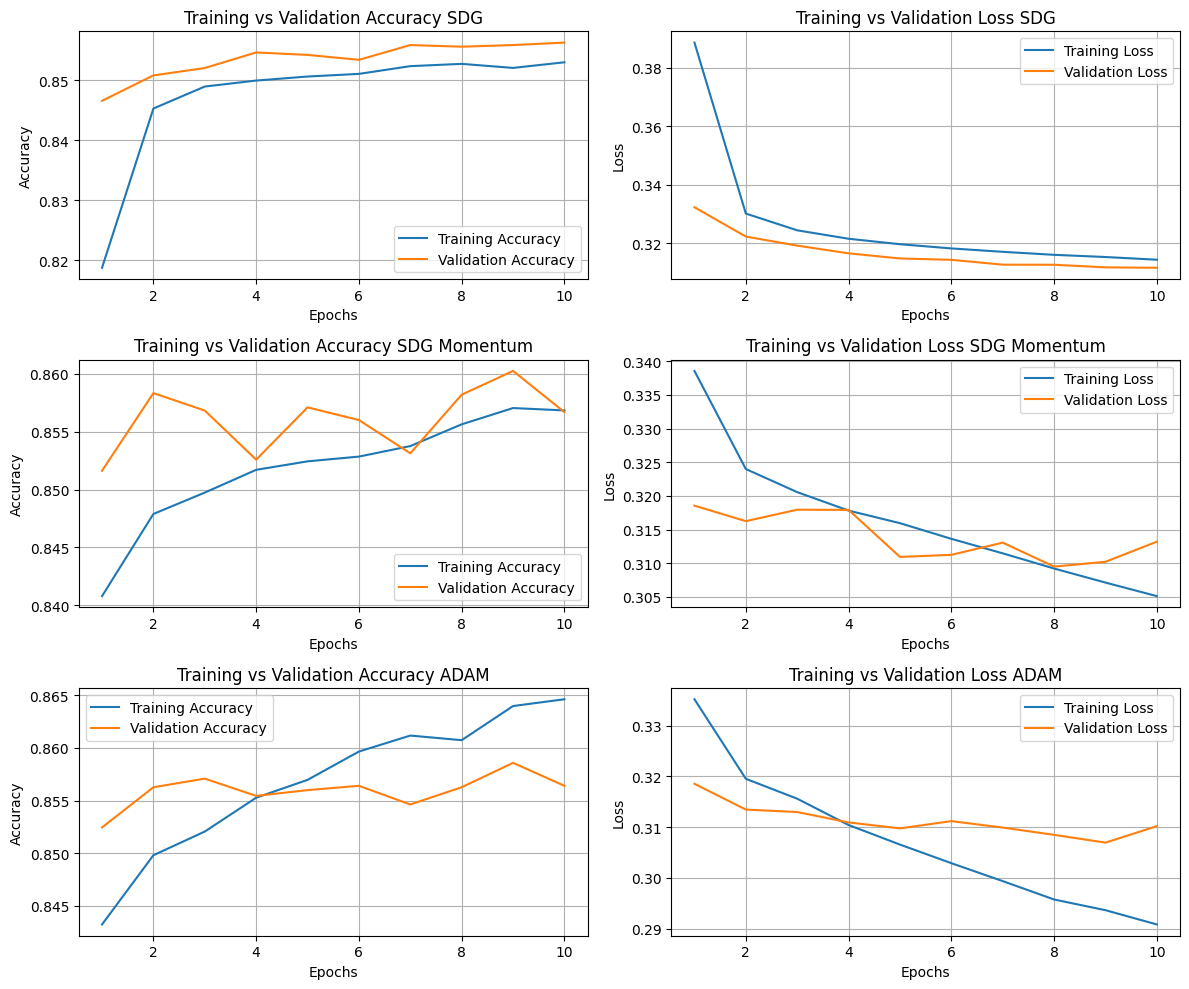

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 10))
#SDG
plt.subplot(3, 2, 1)
plt.plot(epochs, sdgacc, label='Training Accuracy')
plt.plot(epochs, sdgval_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy SDG')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 2, 2)
plt.plot(epochs, sdgloss, label='Training Loss')
plt.plot(epochs, sdgval_loss, label='Validation Loss')
plt.title('Training vs Validation Loss SDG')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
#---------------------------------
# SDG Momentum
plt.subplot(3, 2, 3)
plt.plot(epochs2, sdgmacc, label='Training Accuracy')
plt.plot(epochs2, sdgmval_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy SDG Momentum')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 2, 4)
plt.plot(epochs2, sdgmloss, label='Training Loss')
plt.plot(epochs2, sdgmval_loss, label='Validation Loss')
plt.title('Training vs Validation Loss SDG Momentum')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
#---------------------------------
#ADAM
plt.subplot(3, 2, 5)
plt.plot(epochs3, adamacc, label='Training Accuracy')
plt.plot(epochs3, adamval_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy ADAM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(3, 2, 6)
plt.plot(epochs3, adamloss, label='Training Loss')
plt.plot(epochs3, adamval_loss, label='Validation Loss')
plt.title('Training vs Validation Loss ADAM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
#---------------------------------
plt.tight_layout()
plt.show()

plt.savefig("64_32_32_output_batch16_Optimization.png", dpi=300)

In [ ]:
df_history = pd.DataFrame({
    "epoch": range(1, len(sdgacc) + 1),
    "sgd_acc": sdgacc,
    "sgd_val_acc": sdgval_acc,
    "sgdm_acc": sdgmacc,
    "sgdm_val_acc": sdgmval_acc,
    "adam_acc": adamacc,
    "adam_val_acc": adamval_acc,
})
df_history.head(10)

,epoch,sgd_acc,sgd_val_acc,sgdm_acc,sgdm_val_acc,adam_acc,adam_val_acc
0,1,0.818757,0.846564,0.840805,0.851619,0.843206,0.852439
1,2,0.845284,0.850799,0.847890,0.858314,0.849794,0.856265
2,3,0.848944,0.852029,0.849735,0.856811,0.852048,0.857084
3,4,0.849940,0.854625,0.851697,0.852575,0.855269,0.855445
4,5,0.850613,0.854215,0.852429,0.857084,0.856967,0.855991
5,6,0.851053,0.853395,0.852839,0.855991,0.859661,0.856401
6,7,0.852341,0.855855,0.853746,0.853122,0.861184,0.854625
7,8,0.852722,0.855581,0.855620,0.858177,0.860744,0.856265
8,9,0.852048,0.855855,0.857026,0.860227,0.863994,0.858587
9,10,0.852985,0.856265,0.856821,0.856674,0.864639,0.856401


1. SDG -> Slowest Convergence
2. SDG + Momentum -> Slightly better than plain SDG
3. ADAM -> Highest training accuravcy fastest Convergence

- Adam converges the fastest.

- After just 3 epochs, Adam reaches 85.2% accuracy, while SGD reached that accuracy around epoch 5 to 6.

- Adam's training curve rises more steeply, meaning it learns faster.

Adam combines:

- Momentum -> Uses past gradients to smooth updates.

- Adaptive Learning Rates -> Each parameter has its own learning rate that adjusts automatically based on gradient magnitudes.

## Part 2: Batch Size
1. Train the same model with different batch sizes (e.g., 1, 32, 128, 1024).
2. Compare:
   - Training speed
   - Validation accuracy
   - Test accuracy
   - Generalization ability
3. Which batch size leads to the **noisiest gradient updates**?
4. Which batch size generalizes better and why?

In [65]:
batch_sizes = [1, 16, 32, 128, 1024]
histories = {}

In [74]:
for bs in batch_sizes:
    print(f"\nTraining with batch size = {bs}")
    model = Sequential([
        Input(shape=(85,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    start = time.time()
    history = model.fit(
        xtrain, ytrain,
        validation_data=(xval, yval),
        epochs=20,
        batch_size=bs,
        verbose=2
    )
    time.sleep(1)
    end = time.time()
    print(f"Total runtime of batch {bs} is {end - start} seconds")

    histories[bs] = history.history


Training with batch size = 1
Epoch 1/20
34153/34153 - 67s - 2ms/step - accuracy: 0.8430 - loss: 0.3349 - val_accuracy: 0.8559 - val_loss: 0.3169
Epoch 2/20
34153/34153 - 67s - 2ms/step - accuracy: 0.8494 - loss: 0.3241 - val_accuracy: 0.8504 - val_loss: 0.3167
Epoch 3/20
34153/34153 - 80s - 2ms/step - accuracy: 0.8521 - loss: 0.3196 - val_accuracy: 0.8569 - val_loss: 0.3121
Epoch 4/20
34153/34153 - 65s - 2ms/step - accuracy: 0.8534 - loss: 0.3162 - val_accuracy: 0.8559 - val_loss: 0.3128
Epoch 5/20
34153/34153 - 83s - 2ms/step - accuracy: 0.8569 - loss: 0.3141 - val_accuracy: 0.8553 - val_loss: 0.3134
Epoch 6/20
34153/34153 - 65s - 2ms/step - accuracy: 0.8561 - loss: 0.3125 - val_accuracy: 0.8580 - val_loss: 0.3102
Epoch 7/20
34153/34153 - 81s - 2ms/step - accuracy: 0.8595 - loss: 0.3098 - val_accuracy: 0.8553 - val_loss: 0.3104
Epoch 8/20
34153/34153 - 64s - 2ms/step - accuracy: 0.8593 - loss: 0.3077 - val_accuracy: 0.8591 - val_loss: 0.3135
Epoch 9/20
34153/34153 - 65s - 2ms/step - 

In [77]:
# histories

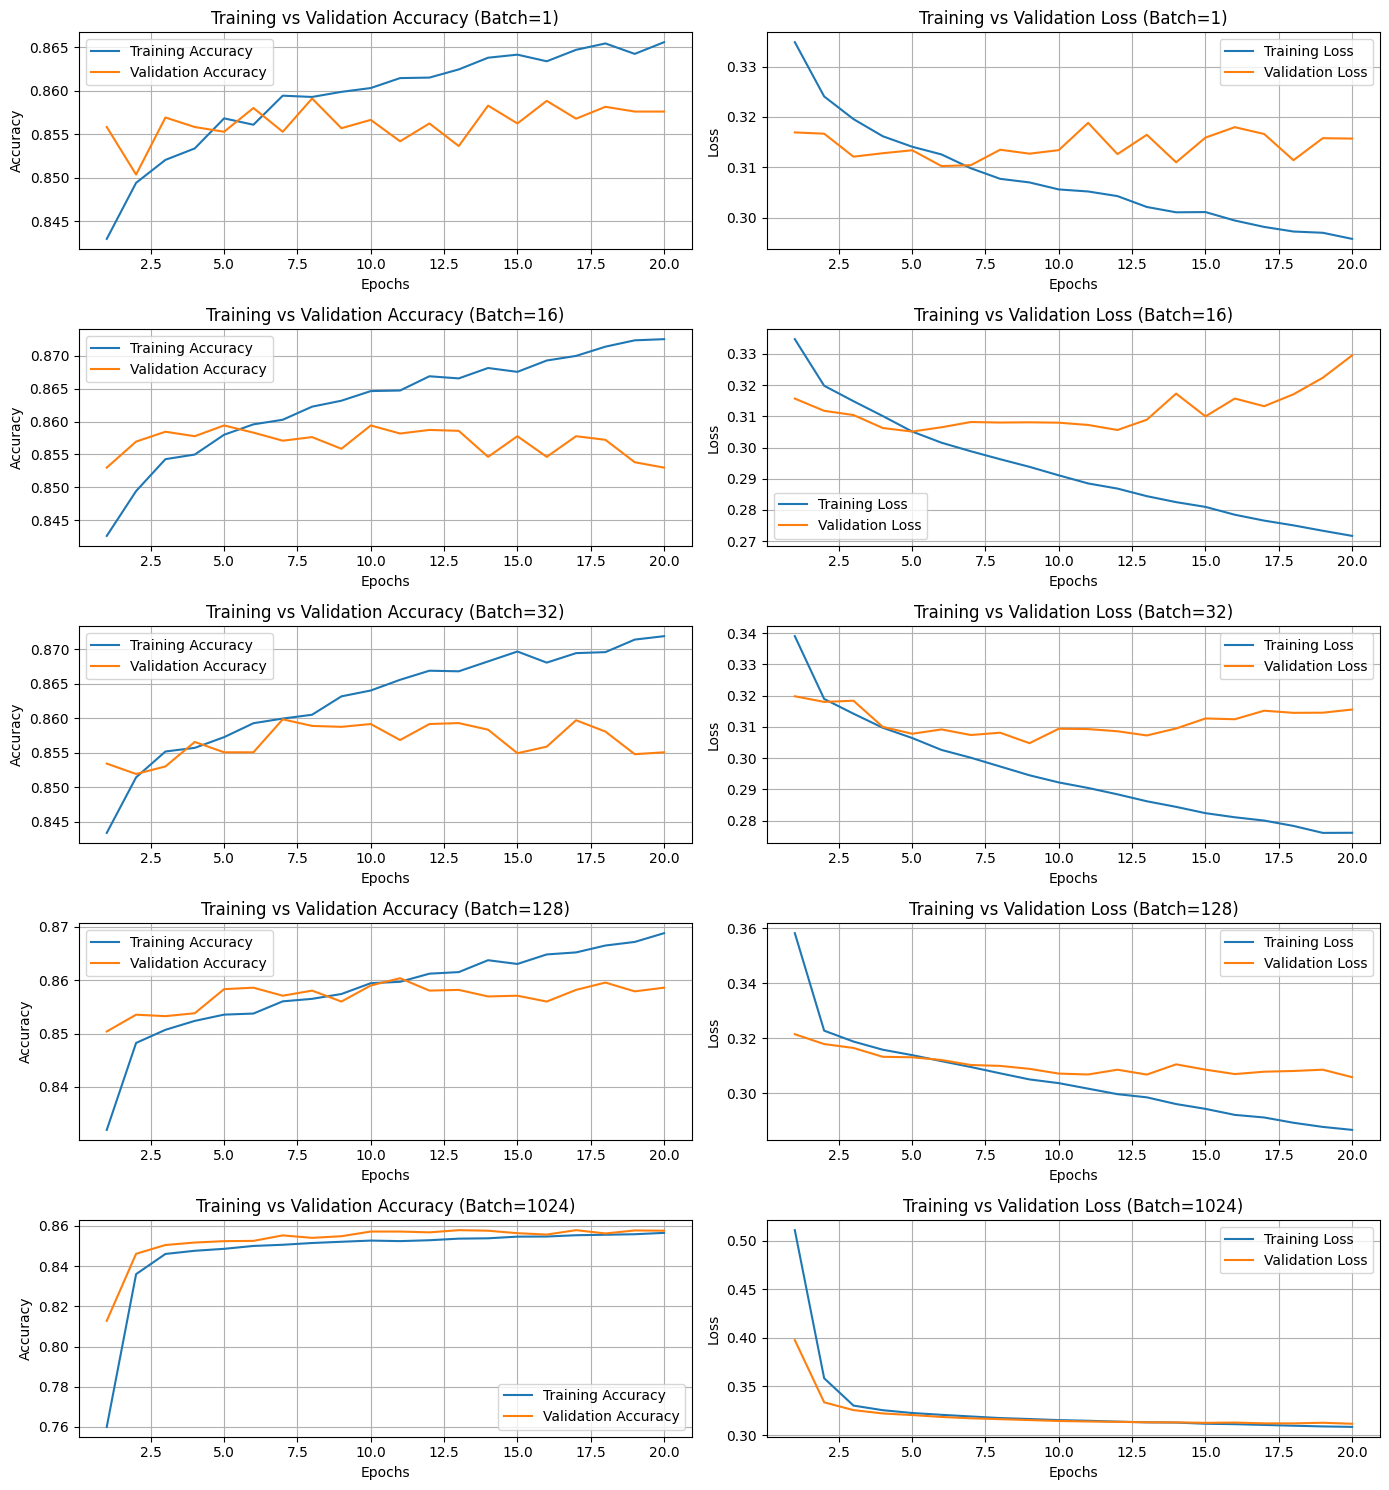

<Figure size 640x480 with 0 Axes>

In [78]:
epochs = np.arange(1, 21)
plt.figure(figsize=(14, 15))
# BATCH SIZE 1 ----------
plt.subplot(5, 2, 1)
plt.plot(epochs, histories[1]['accuracy'], label='Training Accuracy')
plt.plot(epochs, histories[1]['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch=1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(5, 2, 2)
plt.plot(epochs, histories[1]['loss'], label='Training Loss')
plt.plot(epochs, histories[1]['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Batch=1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# --------- BATCH SIZE 16 ----------
plt.subplot(5, 2, 3)
plt.plot(epochs, histories[16]['accuracy'], label='Training Accuracy')
plt.plot(epochs, histories[16]['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(5, 2, 4)
plt.plot(epochs, histories[16]['loss'], label='Training Loss')
plt.plot(epochs, histories[16]['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Batch=16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# --------- BATCH SIZE 32 ----------
plt.subplot(5, 2, 5)
plt.plot(epochs, histories[32]['accuracy'], label='Training Accuracy')
plt.plot(epochs, histories[32]['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch=32)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(5, 2, 6)
plt.plot(epochs, histories[32]['loss'], label='Training Loss')
plt.plot(epochs, histories[32]['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Batch=32)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# --------- BATCH SIZE 128 ----------
plt.subplot(5, 2, 7)
plt.plot(epochs, histories[128]['accuracy'], label='Training Accuracy')
plt.plot(epochs, histories[128]['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch=128)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(5, 2, 8)
plt.plot(epochs, histories[128]['loss'], label='Training Loss')
plt.plot(epochs, histories[128]['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Batch=128)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# --------- BATCH SIZE 1024 ----------
plt.subplot(5, 2, 9)
plt.plot(epochs, histories[1024]['accuracy'], label='Training Accuracy')
plt.plot(epochs, histories[1024]['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch=1024)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(5, 2, 10)
plt.plot(epochs, histories[1024]['loss'], label='Training Loss')
plt.plot(epochs, histories[1024]['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Batch=1024)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

plt.savefig("Batch_Size_Comparison.png", dpi=300)

- As the batch sizes increased the running time increased drastically
- The more the batches increased the more somilar the gap between training and validation metrics closes making them nearly the same
- The smaller the batch size the quicker it generalizes
- But on the other hand the smaller the batch sie the more it overfit
- the smaller the batch size the noizier it gets



## Part 3: Overfitting and Regularization
1. Train a large neural network (many parameters) on the dataset.
2. Observe training vs. validation accuracy.  
   - Do you see signs of overfitting?
3. Apply regularization techniques:
   - **L2 regularization**
   - **Dropout**
4. Compare the validation results before and after regularization.
5. Which regularization method was more effective in reducing overfitting? Why?

---


In [81]:
model3 = Sequential([
    Input(shape=(85,)),
    Dense(532, activation='relu'),
    Dense(532, activation='relu'),
    Dense(532, activation='relu'),
    Dense(532, activation='relu'),
    Dense(532, activation='relu'),
    Dense(320, activation='relu'),
    Dense(320, activation='relu'),
    Dense(320, activation='relu'),
    Dense(320, activation='relu'),
    Dense(320, activation='relu'),
    Dense(320, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy',
              metrics=['accuracy'])

history3 = model3.fit(xtrain, ytrain,
                    validation_data=(xval, yval),
                    epochs=20,
                    batch_size=32)

Epoch 1/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.8216 - loss: 0.3848 - val_accuracy: 0.8534 - val_loss: 0.3268
Epoch 2/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8499 - loss: 0.3308 - val_accuracy: 0.8534 - val_loss: 0.3205
Epoch 3/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8503 - loss: 0.3264 - val_accuracy: 0.8575 - val_loss: 0.3147
Epoch 4/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.8497 - loss: 0.3236 - val_accuracy: 0.8534 - val_loss: 0.3258
Epoch 5/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.8551 - loss: 0.3221 - val_accuracy: 0.8575 - val_loss: 0.3208
Epoch 6/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8554 - loss: 0.3164 - val_accuracy: 0.8569 - val_loss: 0.3177
Epoch 7/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8567 - loss: 0.3125 - val_accuracy: 0.8580 - val_loss: 0.3125
Epoch 8/20
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8588 -

- It doesnt seem that the model overfits

In [84]:
modeldout = Sequential([
    Input(shape=(85,)),
    Dense(532, activation='relu'),
    Dropout(0.3),

    Dense(532, activation='relu'),
    Dropout(0.3),

    Dense(532, activation='relu'),
    Dropout(0.3),

    Dense(532, activation='relu'),
    Dropout(0.3),

    Dense(532, activation='relu'),
    Dropout(0.3),

    Dense(320, activation='relu'),
    Dropout(0.3),

    Dense(320, activation='relu'),
    Dropout(0.3),

    Dense(320, activation='relu'),
    Dropout(0.3),

    Dense(320, activation='relu'),
    Dropout(0.3),

    Dense(320, activation='relu'),
    Dropout(0.3),

    Dense(320, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

modeldout.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history3 = modeldout.fit(
    xtrain, ytrain,
    validation_data=(xval, yval),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 74s 32ms/step - accuracy: 0.8085 - loss: 0.4040 - val_accuracy: 0.8524 - val_loss: 0.3391
Epoch 2/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8447 - loss: 0.3547 - val_accuracy: 0.8559 - val_loss: 0.3185
Epoch 3/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - accuracy: 0.8466 - loss: 0.3428 - val_accuracy: 0.8522 - val_loss: 0.3266
Epoch 4/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - accuracy: 0.8452 - loss: 0.3457 - val_accuracy: 0.8511 - val_loss: 0.3309
Epoch 5/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8467 - loss: 0.3414 - val_accuracy: 0.8474 - val_loss: 0.3277
Epoch 6/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8510 - loss: 0.3327 - val_accuracy: 0.8535 - val_loss: 0.3427
Epoch 7/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.8475 - loss: 0.3393 - val_accuracy: 0.8513 - val_loss: 0.3234
Epoch 8/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.8482 -

In [85]:
modell2 = Sequential([
    Input(shape=(85,)),
    Dense(532, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(532, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(532, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(532, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(532, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(320, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(320, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(320, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(320, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(320, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(320, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

modell2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history3 = modell2.fit(
    xtrain, ytrain,
    validation_data=(xval, yval),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7562 - loss: 4.8274 - val_accuracy: 0.7606 - val_loss: 0.5504
Epoch 2/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.7624 - loss: 0.5488 - val_accuracy: 0.7606 - val_loss: 0.5508
Epoch 3/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7607 - loss: 0.5507 - val_accuracy: 0.7606 - val_loss: 0.5512
Epoch 4/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7531 - loss: 0.5591 - val_accuracy: 0.7606 - val_loss: 0.5504
Epoch 5/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7609 - loss: 0.5505 - val_accuracy: 0.7606 - val_loss: 0.5504
Epoch 6/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7601 - loss: 0.5514 - val_accuracy: 0.7606 - val_loss: 0.5504
Epoch 7/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.7626 - loss: 0.5486 - val_accuracy: 0.7606 - val_loss: 0.5506
Epoch 8/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.7643 -

- Dropout (0.3) worked better it gave 85% validation accuracy and stable loss, showing good generalization and reduced overfitting.
- L2 (0.01) caused underfitting and validation accuracy stayed flat 76%, loss stayed high.

## Part 4: Early Stopping
1. Train the model for many epochs without early stopping.  
   - Plot training, validation, and test curves.
2. Train again with **early stopping** (monitor validation loss).
3. Compare the number of epochs trained and the final validation/test accuracy.
4. Explain how early stopping helps prevent overfitting.

---

In [87]:
model_no_es = Sequential([
    Input(shape=(85,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_no_es.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history_no_es = model_no_es.fit(
    xtrain, ytrain,
    validation_data=(xval, yval),
    epochs=100,
    batch_size=16
)

Epoch 1/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8317 - loss: 0.3639 - val_accuracy: 0.8542 - val_loss: 0.3173
Epoch 2/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8480 - loss: 0.3218 - val_accuracy: 0.8515 - val_loss: 0.3140
Epoch 3/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8529 - loss: 0.3107 - val_accuracy: 0.8569 - val_loss: 0.3099
Epoch 4/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8546 - loss: 0.3111 - val_accuracy: 0.8560 - val_loss: 0.3090
Epoch 5/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8561 - loss: 0.3072 - val_accuracy: 0.8598 - val_loss: 0.3074
Epoch 6/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8600 - loss: 0.3022 - val_accuracy: 0.8554 - val_loss: 0.3115
Epoch 7/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8607 - loss: 0.2966 - val_accuracy: 0.8606 - val_loss: 0.3045
Epoch 8/100
2135/2135 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8597 - loss: 

In [89]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_es = Sequential([
    Input(shape=(85,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_es.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_es = model_es.fit(
    xtrain, ytrain,
    validation_data=(xval, yval),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8179 - loss: 0.3790 - val_accuracy: 0.8538 - val_loss: 0.3179
Epoch 2/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8458 - loss: 0.3264 - val_accuracy: 0.8559 - val_loss: 0.3135
Epoch 3/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8528 - loss: 0.3126 - val_accuracy: 0.8553 - val_loss: 0.3117
Epoch 4/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8567 - loss: 0.3080 - val_accuracy: 0.8554 - val_loss: 0.3116
Epoch 5/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8564 - loss: 0.3034 - val_accuracy: 0.8545 - val_loss: 0.3119
Epoch 6/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8564 - loss: 0.3067 - val_accuracy: 0.8586 - val_loss: 0.3075
Epoch 7/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8576 - loss: 0.3028 - val_accuracy: 0.8605 - val_loss: 0.3093
Epoch 8/100
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8599 - loss: 0

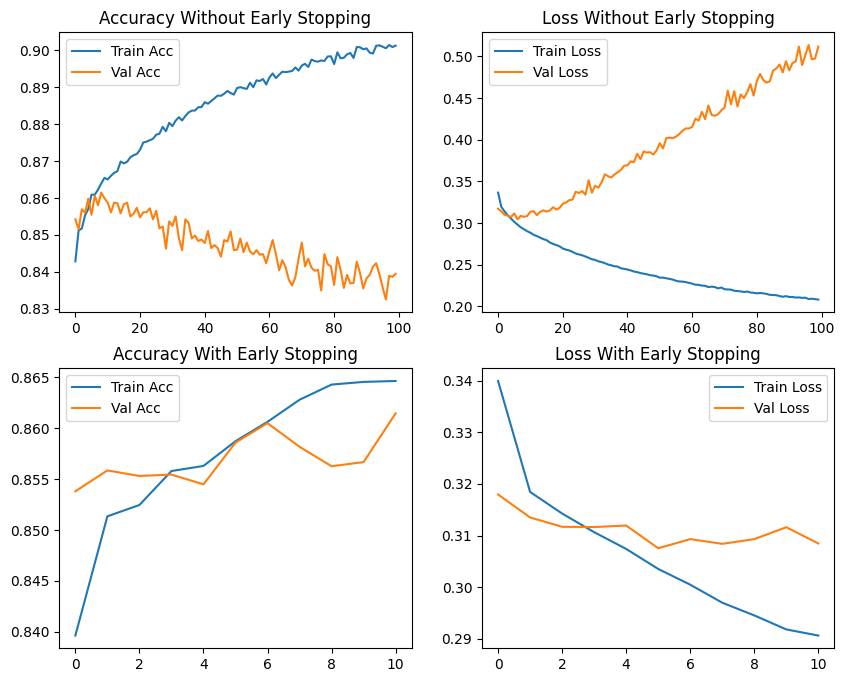

In [90]:
plt.figure(figsize=(10,8))
# Without ES
plt.subplot(2,2,1)
plt.plot(history_no_es.history['accuracy'], label='Train Acc')
plt.plot(history_no_es.history['val_accuracy'], label='Val Acc')
plt.legend(), plt.title("Accuracy Without Early Stopping")

plt.subplot(2,2,2)
plt.plot(history_no_es.history['loss'], label='Train Loss')
plt.plot(history_no_es.history['val_loss'], label='Val Loss')
plt.legend(), plt.title("Loss Without Early Stopping")
# With ES
plt.subplot(2,2,3)
plt.plot(history_es.history['accuracy'], label='Train Acc')
plt.plot(history_es.history['val_accuracy'], label='Val Acc')
plt.legend(), plt.title("Accuracy With Early Stopping")

plt.subplot(2,2,4)
plt.plot(history_es.history['loss'], label='Train Loss')
plt.plot(history_es.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss With Early Stopping")

plt.show()

- Early stopping proved that it prevented overfitting greatly since without it trainig acc 90% and validation was 83%
- While with early stopping it stopped at 86% training and 86% validation
- Epochs without->100, Epoch early stopping -> 11
- The loss scores without early stopping had alot of noise and it didnt generalize well and wasted time and kept increasing steeply

## Part 5: Reflection
1. Summarize what you learned about:
   - The role of optimizers
   - The effect of batch size
   - Regularization methods
   - Early stopping
   - Train/validation/test splits
2. If you had to train a deep learning model on a new tabular dataset, what choices would you make for:
   - Optimizer
   - Batch size
   - Regularization
   - Early stopping
   - Data splitting strategy  
   and why?

# 1
- From my observations the best i got without overfitting or underfitting was 86% validation score and when i tried a small sample of the data it reached 100% which means that the problem is not in the model scince it learns the data well but in the data itself it reached a bottle neck which means some preprocessing steps must be added to increase accuracy.
- The Optimizers control how weights are apdated during training
1. SDG was simpler and needs tuning using momentum to smoth the process, convergence is slow
2. Adam adapts its learning rate automatically and converges faster
- Small batches led to better generalization(not much here because the bottle neck of the data), but slower training and noisy updates
- Large batchhes smother updates faster training risk of overfitting since its like throwing the whole data into the model
- Regularization helps reduce overfitting by controling model learning and complexity
1. Dropout disables neurons (worked better)
2. l2 regularization penelaizes large weights, may underfit
- Earrly stopping prevents overfitting and saved time and restores the best weigts


# 2
It depends on the data and flow
1. test layers and neorons
2. large Batch size if my dataset is large so the training doesnt take a long time, small otherwise
3. Adam optimizer
4. Drop out to make the model learn the data more clearly
5. early stopping when the mpdel tends to overfit with more epochs
